# Modeling

In [68]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# import data
df = pd.read_csv("train.csv")
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_sqft_lot,log_sqft_lot15,mean_log_price_zip
0,622500.0,3,2.5,2290,14374,2.0,0,0,3,8,...,-122.074,2290,33450,13.341499,7.736307,7.736307,7.736307,9.573176,10.417807,13.532819
1,400000.0,3,2.5,2090,32718,2.0,1,4,3,7,...,-122.511,1200,192268,12.899220,7.346010,7.644919,7.090077,10.395681,12.166646,13.007341
2,455000.0,2,1.5,1310,12196,1.5,0,0,3,6,...,-122.122,2970,12196,13.028053,7.177782,7.177782,7.996317,9.408863,9.408863,13.327543
3,159075.0,4,1.5,1580,6200,1.0,0,0,3,6,...,-122.240,1320,6499,11.977131,6.672033,7.365180,7.185387,8.732305,8.779404,12.547945
4,555000.0,2,1.5,1780,4750,1.0,0,0,4,7,...,-122.395,1690,5962,13.226723,6.984716,7.484369,7.432484,8.465900,8.693161,13.213049


# 1.1 Select Features

To select the best features I will use the absolute value of pearson's correlation with the log of price. I will not use any two columns together if they have an absolute correlation over 0.6.

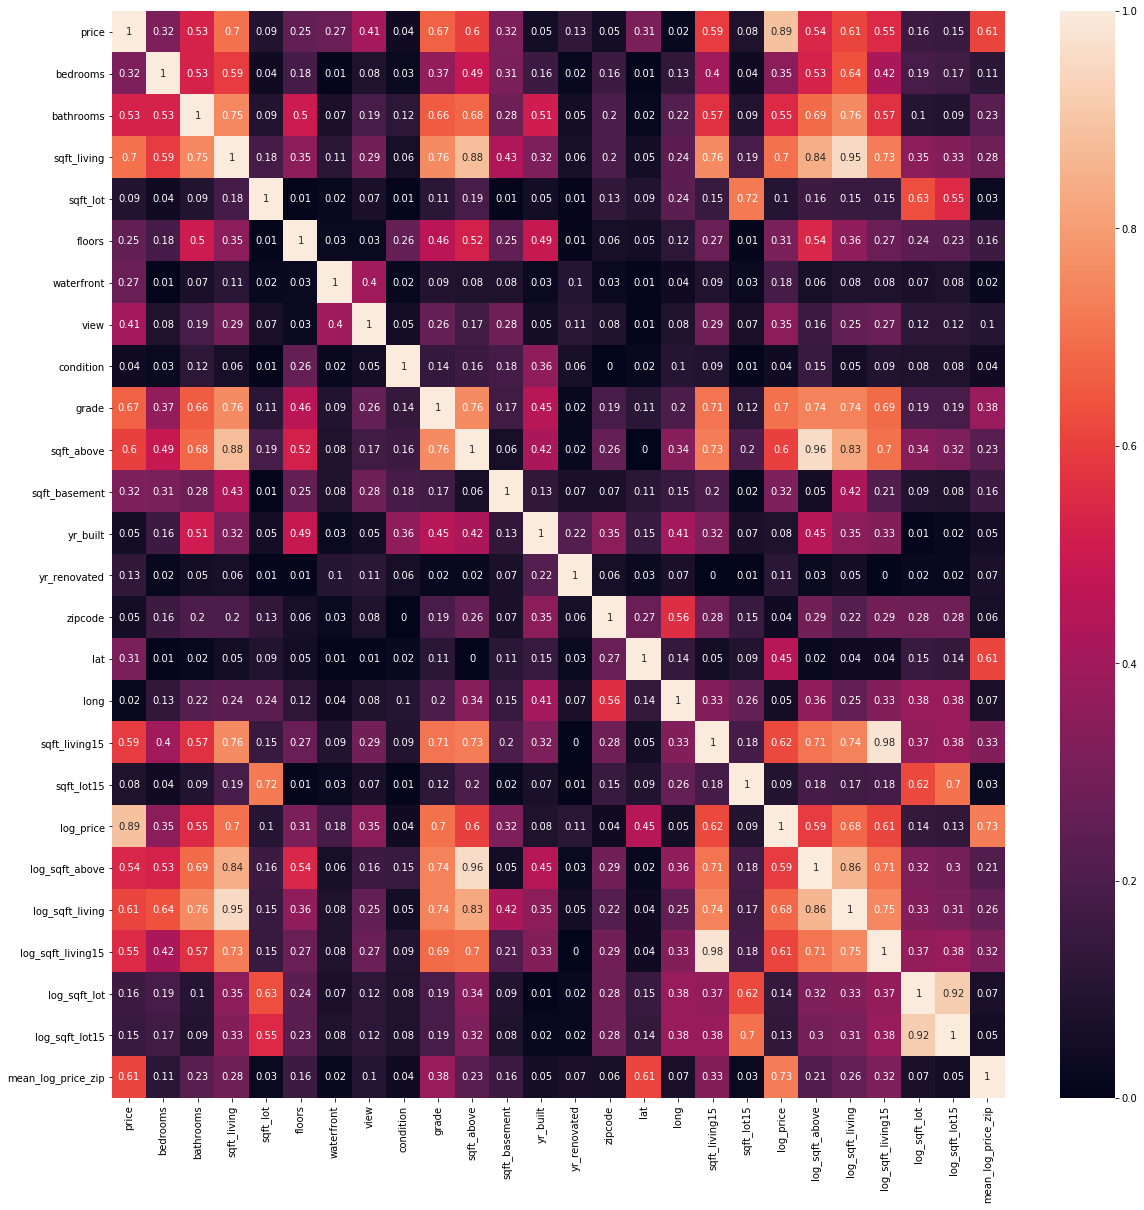

In [9]:
# plot absolute correlations
plt.figure(figsize=(20, 20))
sns.heatmap(round(abs(df.corr()), 2), annot=True)
plt.show()

The best columns are sqft_living and grade, and mean_log_price_zip. A problem arises where grade and sqft_living are correlated so I will try them both out for good measure. Note that since the grade had such a clear linear relationship, I am deciding not to use one-hot-encoding.

# 1.2 Preprocessing

Now I will seperate the data into X and y sets, as well as scale the data with standardization.

In [13]:
X = df[["sqft_living", "grade", "mean_log_price_zip"]]
y = df["log_price"]

sc = StandardScaler()
X = sc.fit_transform(X)

# 1.3 Linear Regression

I will use ridge regression with different combinations of features and see which are the best. Then I will tune the regularization hyperparameter to see if that can improve the results.

### Model Using Only One Feature

In [58]:
# create a default ridge model
ridge = Ridge()

In [71]:
# loop through features and get mse and r^2 for each one
feats = ["sqft_living", "grade", "mean_log_price_zip"]
mses = []
r2s = []


for feat in [0, 1, 2]:
    y_hat = cross_val_predict(ridge, X[:, feat].reshape(-1, 1), y, cv=5)
    mses.append(mean_squared_error(y, y_hat))
    r2s.append(r2_score(y, y_hat))

In [72]:
pd.DataFrame(zip(feats, mses, r2s), columns=["feat", "mse", "r2"])

,feat,mse,r2
0,sqft_living,0.143595,0.483465
1,grade,0.140007,0.496374
2,mean_log_price_zip,0.130773,0.529589


### Model grade and zipcode

In [73]:
y_hat = cross_val_predict(ridge, X[:, 1:], y, cv=5)
print(mean_squared_error(y, y_hat))
print(r2_score(y, y_hat))

0.07073487515455543
0.7455552280211512


### Model sqft_living and zipcode

In [76]:
y_hat = cross_val_predict(ridge, X[:, [0, -1]], y, cv=5)
print(mean_squared_error(y, y_hat))
print(r2_score(y, y_hat))

0.05831946007295197
0.7902154815744213


It seems that using sqft_living and the mean_log_price_zipcode features returned the best results. Let's try adjusting the hyperparameters (regularization) to see if we can fine tune the model.

In [97]:
# take grade out of X
X = X[:, [0, -1]]

In [98]:
# try searching for better alpha (regularization) values
gs = GridSearchCV(ridge, {"alpha":[0.1, 0.5, 1, 2, 10]}, cv=5, scoring="neg_mean_squared_error")
gs.fit(X, y)
# find best alpha
print(gs.best_params_)
# print score
print(gs.best_score_)

{'alpha': 2}
-0.05831945759466741


In [99]:
# try searching for better alpha (regularization) values
gs = GridSearchCV(ridge, {"alpha":[2, 3, 4, 5, 6, 7]}, cv=5, scoring="neg_mean_squared_error")
gs.fit(X, y)
# find best alpha
print(gs.best_params_)
# print score
print(gs.best_score_)

{'alpha': 3}
-0.05831945635857199


It seems like an alpha of 3 will work well. The score did not change much, but a higher alpha level will reduce the chances of overfitting

Now I will check that the errors are normally distributed and that there is no heteroskedascicity (change in variance of errors).

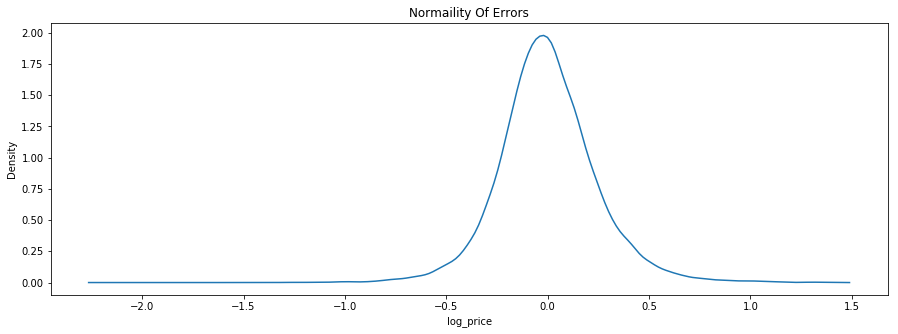

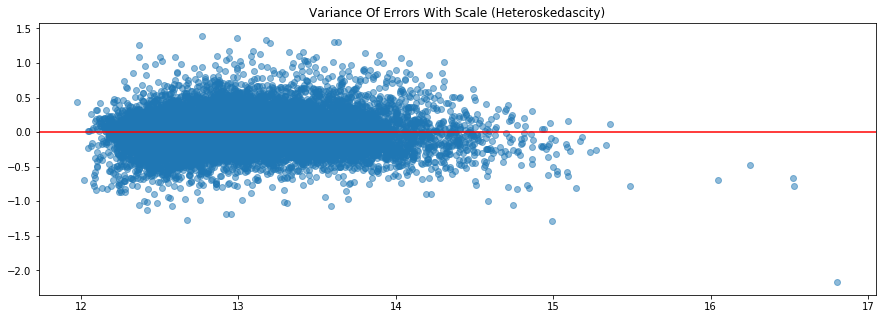

In [101]:
ridge = gs.best_estimator_

y_hat = ridge.predict(X)

errors = y - y_hat

# plot for normality
plt.figure(figsize=(15, 5))
sns.kdeplot(errors)
plt.title("Normaility Of Errors")
plt.show()

# plot for heteroskedascity
plt.figure(figsize=(15, 5))
plt.scatter(y_hat, errors, alpha=0.5)
plt.axhline(errors.mean(), color="red")
plt.title("Variance Of Errors With Scale (Heteroskedascity)")
plt.show()

It seems the model holds up well until the price gets extremely large.

## Interpreting Results

Now it is time to interpret the model. First let's take a look at the R-squared

In [95]:
r2_score(y, y_hat)

0.7903474507206611

The R-squared value indicates that the log of the price is approximately %79 related to the mean zipcode log price and the sqft living space. In other words atleast %21 is not predictable with this model and these features.

The second thing to look at is the coefficients. These are hard to interpret on their own as they are relative to the feature. So therefore I will print out some descriptive statistics for the features as well.

In [109]:
# print out model coefficients
feats.remove("grade")
dict(zip(feats, ridge.coef_))

{'sqft_living': 0.2806003810230018, 'mean_log_price_zip': 0.30435783356493906}

In [ ]:
df["sqft_living"].std(), df["sqft_log_price_zip"].std()